In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
projectFolderPath = "/content/drive/MyDrive/CUB/Data Mining/"

trainDataPath = projectFolderPath + "preprocessed_train.csv"
testDataPath = projectFolderPath + "preprocessed_test.csv"

trainDF = pd.read_csv(trainDataPath, on_bad_lines = 'skip')
trainDF.head()

,text,label,preprocessed_text
0,Do you want to hear a story? So I was at work ...,0,want hear stori work caus scientist friend ar...
1,The author does a really good job with explain...,0,author realli good job explain great detail tz...
2,I think that you guys should all become a Seag...,0,think guy becom seago cowboy adventur world ri...
3,Why should the people Of the United States vot...,0,peopl unit state vote elector vote jolt one co...
4,"Senator, I believe that voting for the Preside...",0,senat believ vote presid unit state base popu...


In [4]:
testDF = pd.read_csv(testDataPath, on_bad_lines = 'skip')
testDF.head()

,text,label,preprocessed_text
0,The Face on Mars is nothing but a natural occu...,0,face mar noth natur occurr mar thing call ba...
1,Students have a higher chance of catching a vi...,0,student higher chanc catch viru school hour v...
2,Driverless cars have good and bad things that ...,0,driverless car good bad thing would go along ...
3,Some people might think that traveling in a gr...,1,peopl might think travel group led tour guid g...
4,How many of us students want to be forced to d...,0,mani us student want forc someth probabl mani...


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def generateEmbeddings(corpus, vectorizer_type, max_features):
    assert vectorizer_type in ['CountVectorizer', 'TfidfVectorizer'], "vectorizer must be either CountVectorizer or TfidfVectorizer"

    vectorizer = CountVectorizer()
    if vectorizer_type == 'CountVectorizer':
        vectorizer = CountVectorizer() if max_features is None else CountVectorizer(max_features = max_features, vocabulary = None)
    else:
        vectorizer = TfidfVectorizer() if max_features is None else TfidfVectorizer(max_features = max_features, vocabulary = None)

    embeddings = vectorizer.fit_transform(corpus)
    return embeddings

def removeNpNan(trainDF):
    preprocessed_text_list = list(trainDF['preprocessed_text'])
    labelList = list(trainDF['label'])
    npNanRows = list()
    for i in range(len(preprocessed_text_list)):
        if preprocessed_text_list[i] is np.nan:
            npNanRows.append(i)

    newPreProcessedText = list()
    newLabels = list()

    for i in range(len(preprocessed_text_list)):
        if not i in npNanRows:
            newPreProcessedText.append(preprocessed_text_list[i])
            newLabels.append(labelList[i])

    trainDF = pd.DataFrame()
    trainDF['preprocessed_text'] = newPreProcessedText
    trainDF['label'] = newLabels

    return trainDF

In [6]:
trainDF = removeNpNan(trainDF)

In [7]:
X_train_CV = generateEmbeddings(trainDF['preprocessed_text'], 'CountVectorizer', 2000)
X_test_CV = generateEmbeddings(testDF['preprocessed_text'], 'CountVectorizer', 2000)

X_train_tfidf = generateEmbeddings(trainDF['preprocessed_text'], 'TfidfVectorizer', 2000)
X_test_tfidf = generateEmbeddings(testDF['preprocessed_text'], 'TfidfVectorizer', 2000)

print(f"X_train_CV.shape = {X_train_CV.shape}")
print(f"X_test_CV.shape = {X_test_CV.shape}")
print(f"X_train_tfidf.shape = {X_train_tfidf.shape}")
print(f"X_test_tfidf.shape = {X_test_tfidf.shape}")

X_train_CV.shape = (249645, 2000)
X_test_CV.shape = (86587, 2000)
X_train_tfidf.shape = (249645, 2000)
X_test_tfidf.shape = (86587, 2000)


In [8]:
y_train = trainDF["label"]
y_test = testDF["label"]

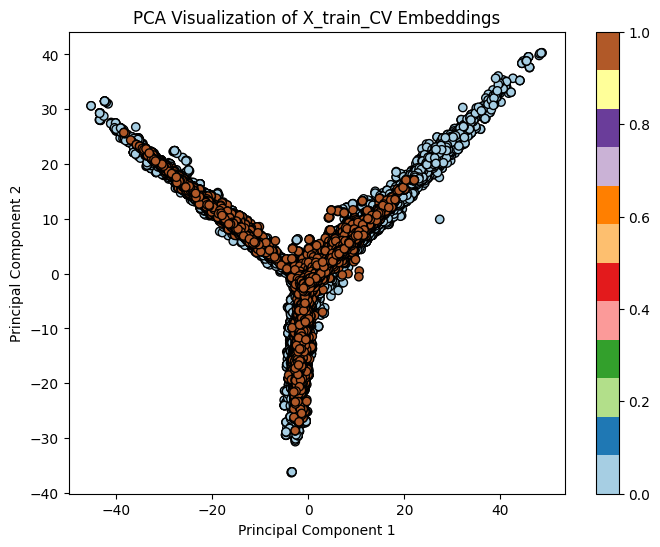

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming X_train_CV is your count vectorizer embeddings and y_train is your class labels

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_train_CV_pca = pca.fit_transform(X_train_CV.toarray())

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(X_train_CV_pca[:, 0], X_train_CV_pca[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolor='k')
plt.title('PCA Visualization of X_train_CV Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

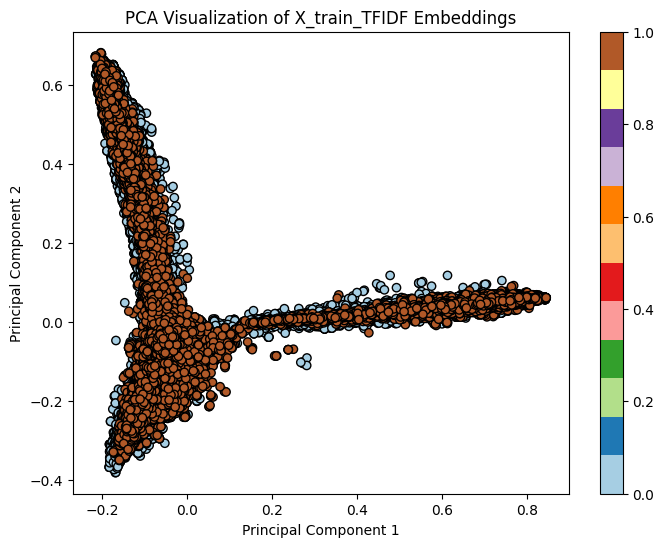

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming X_train_CV is your count vectorizer embeddings and y_train is your class labels

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_train_TFIDF_pca = pca.fit_transform(X_train_tfidf.toarray())

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(X_train_TFIDF_pca[:, 0], X_train_TFIDF_pca[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolor='k')
plt.title('PCA Visualization of X_train_TFIDF Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [38]:
from sklearn.svm import LinearSVC

# Initialize LinearSVC model
svm_model_cv = LinearSVC(C=10)

# Train the model
svm_model_cv.fit(X_train_CV, y_train)  # Using CountVectorizer representation

# Make predictions on the test set
y_pred_svm_CV = svm_model_cv.predict(X_test_CV)

# Evaluate the model
accuracy_svm_CV = svm_model_cv.score(X_test_CV, y_test)  # Using CountVectorizer representation


print("LinearSVC Accuracy CV:", accuracy_svm_CV)

# F1 score (harmonic mean of precision and recall)
f1 = f1_score(y_test, y_pred_svm_CV, average = 'binary')  # 'binary' for two classes

# Precision (correctly predicted positives / all predicted positives)
precision = precision_score(y_test, y_pred_svm_CV, average = 'binary')

# Recall (correctly predicted positives / all actual positives)
recall = recall_score(y_test,y_pred_svm_CV, average = 'binary')

# Accuracy (correctly classified / total samples)
accuracy = accuracy_score(y_test, y_pred_svm_CV)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)


LinearSVC Accuracy CV: 0.5448161964267153
F1 Score: 0.4772048972661794
Precision: 0.40289381145429704
Recall: 0.5851278381367511
Accuracy: 0.5448161964267153
    


In [40]:
from sklearn.svm import LinearSVC

# Initialize LinearSVC model
svm_model_tfidf = LinearSVC(C=10)

# Train the model
svm_model_tfidf.fit(X_train_tfidf, y_train)  # Using CountVectorizer representation

# Make predictions on the test set
y_pred_svm_tfidf = svm_model_tfidf.predict(X_test_tfidf)

# Evaluate the model
accuracy_svm_tfidf = svm_model_tfidf.score(X_test_tfidf, y_test)  # Using CountVectorizer representation

print("LinearSVC Accuracy Tfidf:", accuracy_svm_tfidf)

# F1 score (harmonic mean of precision and recall)
f1 = f1_score(y_test, y_pred_svm_tfidf, average = 'binary')  # 'binary' for two classes

# Precision (correctly predicted positives / all predicted positives)
precision = precision_score(y_test, y_pred_svm_tfidf, average='binary')

# Recall (correctly predicted positives / all actual positives)
recall = recall_score(y_test, y_pred_svm_tfidf, average='binary')

# Accuracy (correctly classified / total samples)
accuracy = accuracy_score(y_test, y_pred_svm_tfidf)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

LinearSVC Accuracy Tfidf: 0.5535242010925427
F1 Score: 0.5028996129563192
Precision: 0.4158249516235354
Recall: 0.6361004488972741
Accuracy: 0.5535242010925427
